In [159]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# PreProcessing

### Load Data after EDA

In [160]:
data = pd.read_csv('data_after_eda.csv')
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,VisitorType,target
0,0,0.0,0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,Returning_Visitor,0
1,0,0.0,0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,Returning_Visitor,0
2,0,0.0,0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,Returning_Visitor,0
3,0,0.0,0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,Returning_Visitor,0
4,0,0.0,0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,Returning_Visitor,0


In [161]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  float64
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  VisitorType              12330 non-null  object 
 12  target                   12330 non-null  int64  
dtypes: float64(8), int64(3), object(2)
memory usage: 1.2+ MB


We are observing Categorical and Numerical features in our data.
We will normalize the numerical features and perform onhot encoding on categorical features

### Train Test Data Split

In [162]:
#Devide data as X and y 
y = data['target'].values
X = data.drop(['target'],axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,stratify=y,random_state=5)

print("Train=",X_train.shape, y_train.shape)
print("Test=",X_test.shape, y_test.shape)

Train= (8261, 12) (8261,)
Test= (4069, 12) (4069,)


### Handling Categorical features

In [163]:
#Collecting feature names
top_feature_names =[]


vectorizer = CountVectorizer()

#Converting school state
vectorizer.fit(X_train['VisitorType'].values) # fit has to happen only on train data
top_feature_names.extend(vectorizer.get_feature_names())

# we use the fitted CountVectorizer to convert the text to vector
X_train_visitor_ohe = vectorizer.transform(X_train['VisitorType'].values)
X_test_visitor_ohe = vectorizer.transform(X_test['VisitorType'].values)

#Converting school state
vectorizer.fit(X_train['Month'].values) # fit has to happen only on train data
top_feature_names.extend(vectorizer.get_feature_names())

# we use the fitted CountVectorizer to convert the text to vector
X_train_month_ohe = vectorizer.transform(X_train['Month'].values)
X_test_month_ohe = vectorizer.transform(X_test['Month'].values)


### Handling Numerical features

In [164]:
normalizer = Normalizer()
def transform_numerical_features(feature):
    X_train[feature] = normalizer.fit_transform(X_train[feature].values.reshape(1,-1)).T
    X_test[feature] =  normalizer.fit_transform(X_test[feature].values.reshape(1,-1)).T


In [165]:
for column in X_train.select_dtypes(['int64','float64']):
    transform_numerical_features(column)
    top_feature_names.append(column)

Drop Month and VisitorType from Train and Test

In [166]:
X_train.drop(['Month','VisitorType'],axis=1,inplace=True)
X_test.drop(['Month','VisitorType'],axis=1,inplace=True)

In [167]:
X_train.head()
X_test.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
12021,0.000000,0.000000,0.0,0.0,0.002822,0.002896,0.008253,0.011940,0.0,0.0
8710,0.000000,0.000000,0.0,0.0,0.004435,0.005129,0.000000,0.010855,0.0,0.0
8749,0.003952,0.018872,0.0,0.0,0.008467,0.008684,0.000000,0.002388,0.0,0.0
11731,0.000000,0.000000,0.0,0.0,0.000806,0.001301,0.000000,0.023881,0.0,0.0
6585,0.011856,0.006822,0.0,0.0,0.064108,0.022828,0.000535,0.001335,0.0,0.0


In [168]:
print("Total No.Of features for Feature selection=",len(top_feature_names))

Total No.Of features for Feature selection= 23


### Merge pre-processed data

In [169]:
X_tr = hstack((X_train,X_train_visitor_ohe,X_train_month_ohe ))
X_te = hstack((X_test,X_test_visitor_ohe,X_test_month_ohe ))

In [170]:
print(X_tr.shape)
print(X_te.shape)

(8261, 23)
(4069, 23)


# Modeling

## Modeling using Decision Tree

In [171]:

dtClassifier = DecisionTreeClassifier(class_weight={1:8,0:2})
#review range
parameters ={'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500]}
clf = GridSearchCV(dtClassifier,parameters,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr,y_train)


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight={0: 2, 1: 8}),
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [172]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values('rank_test_score')[0:3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
11,0.010266,0.000290,0.000901,0.000005,10,500,"{'max_depth': 10, 'min_samples_split': 500}",0.874810,0.877468,0.892155,0.881478,0.007628,1,0.896005,0.901287,0.891211,0.896168,0.004115
15,0.010298,0.000262,0.000957,0.000099,50,500,"{'max_depth': 50, 'min_samples_split': 500}",0.874642,0.877468,0.892155,0.881422,0.007677,2,0.896205,0.901287,0.891211,0.896234,0.004114
7,0.008215,0.000119,0.001022,0.000049,5,500,"{'max_depth': 5, 'min_samples_split': 500}",0.871838,0.874257,0.893127,0.879741,0.009517,3,0.891090,0.894421,0.885512,0.890341,0.003675


### HeatMap for HyperParameter Analysis Visualization

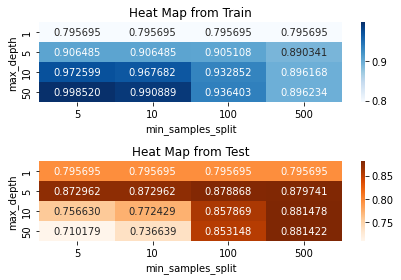

In [173]:
##Heatmap
#https://stackoverflow.com/questions/39041865/three-variables-as-heatmap
import seaborn as sns
import matplotlib.pyplot as plt 

max_depth=results['param_max_depth']
min_samples_split=results['param_min_samples_split']
train_score = results['mean_train_score']
test_score = results['mean_test_score']

fig, ax= plt.subplots(nrows=2)
#https://stackoverflow.com/questions/41659188/how-to-adjust-subplot-size-in-seaborn
plt.rcParams['figure.figsize']=(7,7)

train_roc_auc = pd.DataFrame({'max_depth':max_depth,'min_samples_split':min_samples_split,'train_score':train_score})
test_roc_auc = pd.DataFrame({'max_depth':max_depth,'min_samples_split':min_samples_split,'test_score':test_score})

train_roc_auc = train_roc_auc.pivot('max_depth', 'min_samples_split', 'train_score')
ax[0] = sns.heatmap(train_roc_auc,annot=True, fmt="f",ax=ax[0],cmap='Blues')

# labels, title 
ax[0].set_xlabel('min_samples_split');
ax[0].set_ylabel('max_depth'); 
ax[0].set_title('Heat Map from Train');


test_roc_auc = test_roc_auc.pivot('max_depth', 'min_samples_split', 'test_score')
ax[1] = sns.heatmap(test_roc_auc,annot=True, fmt="f",ax=ax[1],cmap='Oranges')

# labels, title 
ax[1].set_xlabel('min_samples_split');
ax[1].set_ylabel('max_depth'); 
ax[1].set_title('Heat Map from Test');

fig.tight_layout()

### Fetch Best Params for Modeling

In [174]:
##Fetch best permaters
max_depth= clf.best_params_['max_depth']
min_samples_split= clf.best_params_['min_samples_split']
print('Best depth=',max_depth,' Best min samples=',min_samples_split)

Best depth= 10  Best min samples= 500


### Decision Tree Modeling using Best Params

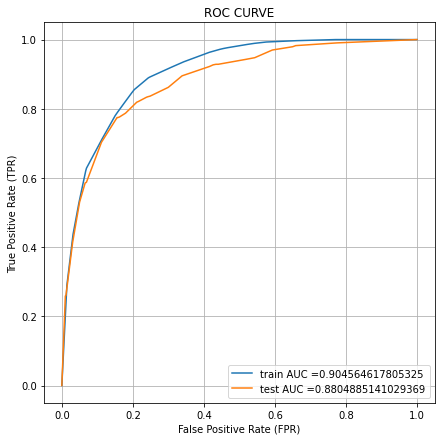

In [175]:
#Pass actual alpha and compute predictions
#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

from sklearn.metrics import roc_curve, auc

dTclf = DecisionTreeClassifier(class_weight={1:8,0:2},max_depth=max_depth,min_samples_split=min_samples_split)
dTclf.fit(X_tr,y_train)

#https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-predict-and-predict-proba/67376/4
y_train_pred = dTclf.predict_proba(X_tr)[:,1]
y_test_pred = dTclf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test,y_test_pred)

#Plot roc curve, AUC cureve
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC CURVE")
plt.grid()
plt.show()

In [176]:
best_auc_dt = str(auc(test_fpr, test_tpr))

### Confusion Matrix

In [177]:
import numpy as np
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print("="*50)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_test_preicted = predict_with_best_t(y_test_pred, best_t)
train_conf = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test_conf = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

the maximum value of tpr*(1-fpr) 0.6808382396147855 for threshold 0.49


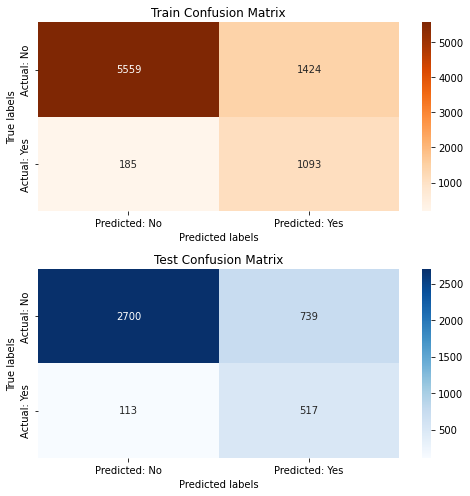

In [178]:
#https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
import seaborn as sns
import matplotlib.pyplot as plt     

fig, ax= plt.subplots(nrows=2)
#https://stackoverflow.com/questions/41659188/how-to-adjust-subplot-size-in-seaborn
plt.rcParams['figure.figsize']=(7,7)

sns.heatmap(train_conf, annot=True,fmt="d",cmap='Oranges',ax=ax[0]);
# labels, title and ticks
ax[0].set_xlabel('Predicted labels');
ax[0].set_ylabel('True labels'); 
ax[0].set_ylim(2.0, 0)
ax[0].set_title('Train Confusion Matrix');
ax[0].xaxis.set_ticklabels(['Predicted: No','Predicted: Yes']); 
ax[0].yaxis.set_ticklabels(['Actual: No','Actual: Yes']);

sns.heatmap(test_conf, annot=True,fmt="d",cmap='Blues',ax=ax[1]);
# labels, title and ticks
ax[1].set_xlabel('Predicted labels');ax[1].set_ylabel('True labels'); 
ax[1].set_ylim(2.0, 0)
ax[1].set_title('Test Confusion Matrix');
ax[1].xaxis.set_ticklabels(['Predicted: No','Predicted: Yes']); 
ax[1].yaxis.set_ticklabels(['Actual: No','Actual: Yes']);


fig.tight_layout()

### Visualize DecisionTree

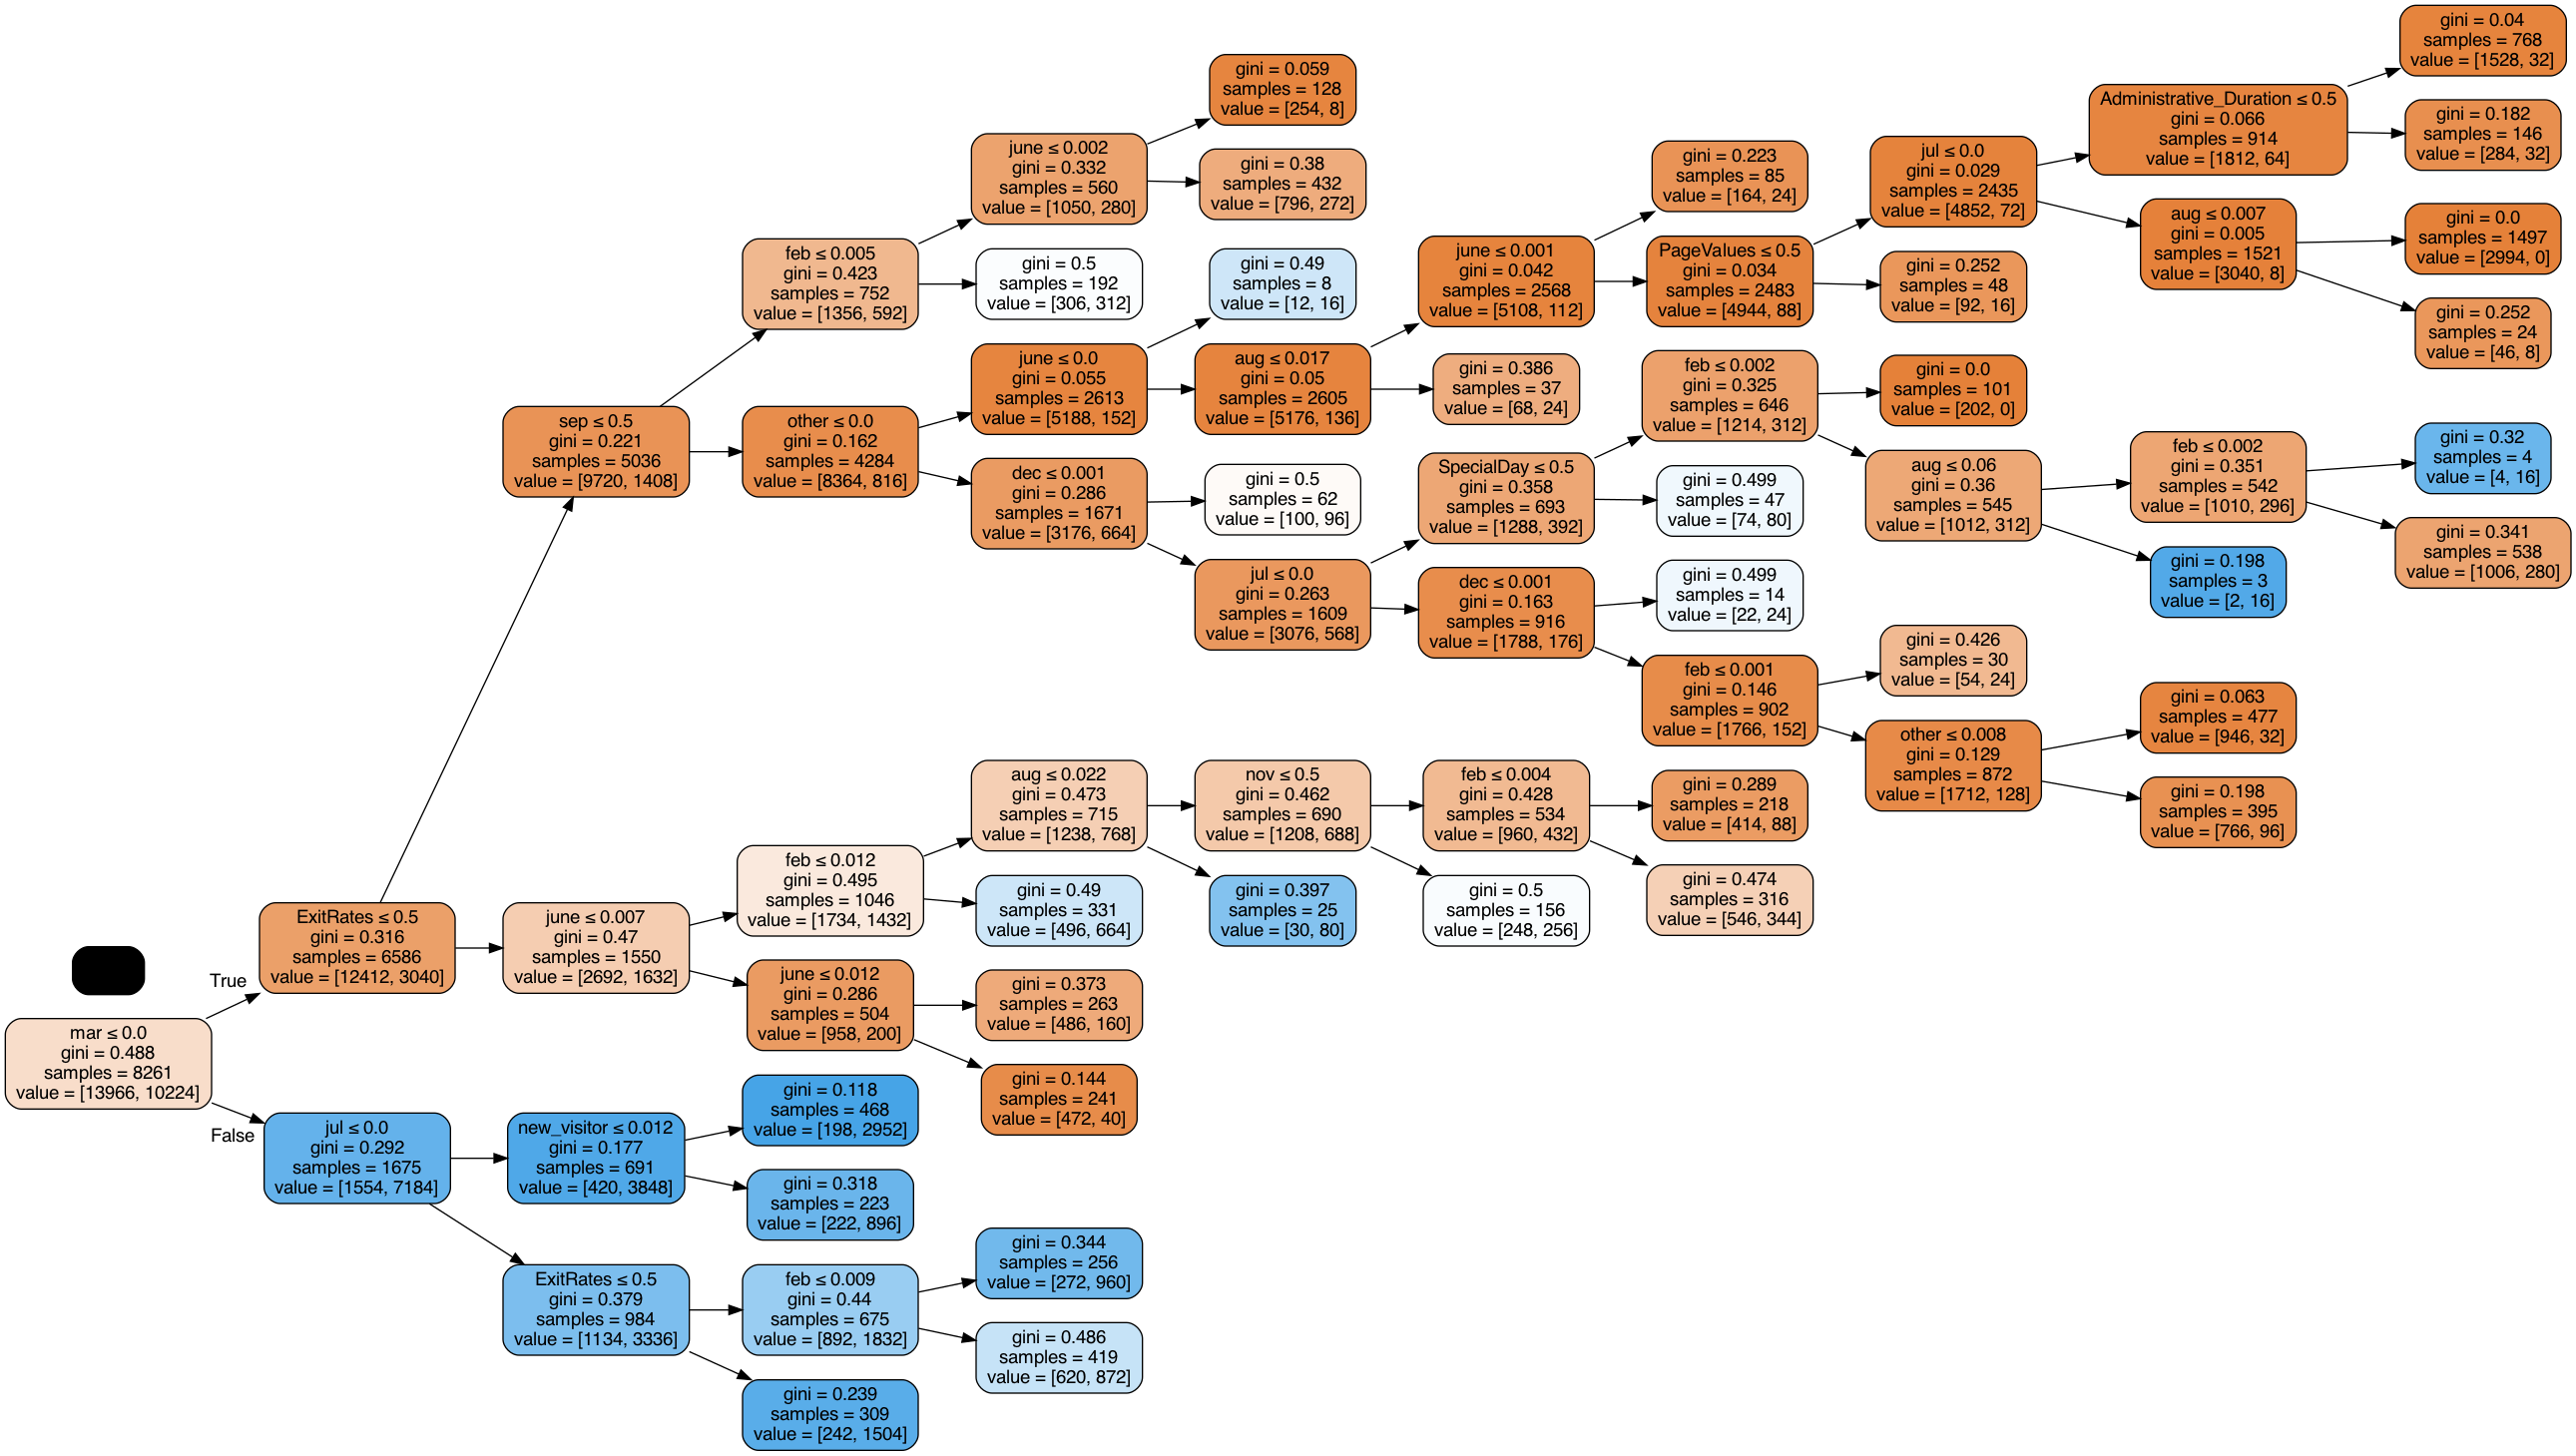

In [179]:
#https://stackoverflow.com/questions/61901365/modulenotfounderror-no-module-named-sklearn-externals-six
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dTclf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=top_feature_names,rotate=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


### Combine test data with predicted and filter False Positive DataPoints

In [180]:
test_data = X_test
test_data['y_actual'] = list(y_test)
test_data['y_pred'] = y_test_preicted

test_data.head(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,y_actual,y_pred
12021,0.000000,0.000000,0.0,0.0,0.002822,0.002896,0.008253,0.011940,0.0,0.0,0,0
8710,0.000000,0.000000,0.0,0.0,0.004435,0.005129,0.000000,0.010855,0.0,0.0,0,1
8749,0.003952,0.018872,0.0,0.0,0.008467,0.008684,0.000000,0.002388,0.0,0.0,0,0
11731,0.000000,0.000000,0.0,0.0,0.000806,0.001301,0.000000,0.023881,0.0,0.0,0,0
6585,0.011856,0.006822,0.0,0.0,0.064108,0.022828,0.000535,0.001335,0.0,0.0,0,0


### Fetch Important Features from DT

In [181]:
#https://stackoverflow.com/questions/36967666/transform-scipy-sparse-csr-to-pandas
X_train_imp_features = pd.DataFrame(None)
X_test_imp_features = pd.DataFrame(None)
X_train_imp_features = pd.DataFrame.sparse.from_spmatrix(X_tr, columns=top_feature_names)
X_test_imp_features = pd.DataFrame.sparse.from_spmatrix(X_te, columns=top_feature_names)

print(X_train_imp_features.shape)
print(X_test_imp_features.shape)

(8261, 23)
(4069, 23)


In [182]:
#https://stackoverflow.com/questions/4588628/find-indices-of-elements-equal-to-zero-in-a-numpy-array
#https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe
print("Totsl No.of Existing Features=",len(dTclf.feature_importances_))
important_features = dTclf.feature_importances_
non_zero_imp_features = np.nonzero(important_features)[0]
print("Total No.Of Important Features=",len(non_zero_imp_features))
X_train_data_with_important_features = X_train_imp_features.iloc[:, non_zero_imp_features]
X_test_data_with_important_features = X_test_imp_features.iloc[:, non_zero_imp_features]

print(X_train_data_with_important_features.shape)
print(X_test_data_with_important_features.shape)


Totsl No.of Existing Features= 23
Total No.Of Important Features= 14
(8261, 14)
(4069, 14)


In [183]:
X_train_data_with_important_features.head()

,new_visitor,other,aug,dec,feb,jul,june,mar,nov,sep,Administrative_Duration,ExitRates,PageValues,SpecialDay
0,0.013455,0.004301,0.0,0.008169,0.004094,0.000000,0.000355,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.000000,0.000000,0.0,0.003812,0.002931,0.008922,0.014197,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.000000,0.000000,0.0,0.008169,0.005479,0.005205,0.007986,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.000545,0.000486,0.000000,0.017036,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.000000,0.000000,0.0,0.001634,0.002704,0.027758,0.028393,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Modeling using Logistic Regression

We will use important features extracted and use here for LR

### Conver Data to Sparse matrix

In [184]:
from scipy.sparse import csr_matrix
#https://stackoverflow.com/questions/20459536/convert-pandas-dataframe-to-sparse-numpy-matrix-directly
X_train_data_imp_features = csr_matrix(X_train_data_with_important_features.values)
X_test_data_imp_features= csr_matrix(X_test_data_with_important_features.values)
print(X_train_data_imp_features.shape)
print(X_test_data_imp_features.shape)

(8261, 14)
(4069, 14)


### Find best Hyperparams using Cross validation

In [185]:
#Impliment find best Hyperparams using Cross validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

parameters = {'C':  np.logspace(-10, 2, num=40, endpoint=True, base=10.0, dtype=None, axis=0)}
randomSearchclf = RandomizedSearchCV(clf,parameters,cv=3,return_train_score=True,scoring='roc_auc')
randomSearchclf.fit(X_train_data_imp_features,y_train)

svc_result = pd.DataFrame.from_dict(randomSearchclf.cv_results_)
best_hyper_param = randomSearchclf.best_params_['C'];
print('Best Hyperparameters=',best_hyper_param)

Best Hyperparameters= 100.0


In [186]:
svc_result.sort_values('rank_test_score')[0:3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
9,0.026603,0.000514,0.000752,0.000023,100.0,{'C': 100.0},0.865537,0.862624,0.872472,0.866878,0.004131,1,0.872305,0.874591,0.866577,0.871158,0.003371
2,0.017300,0.001406,0.000770,0.000036,2.894266,{'C': 2.8942661247167516},0.804119,0.817210,0.800745,0.807358,0.007101,2,0.812284,0.810753,0.810155,0.811064,0.000897
8,0.005669,0.000242,0.000740,0.000008,0.020309,{'C': 0.02030917620904739},0.714172,0.731958,0.715648,0.720593,0.008059,3,0.723075,0.711502,0.730429,0.721669,0.007791


### Modeling Using Logisitc Regression

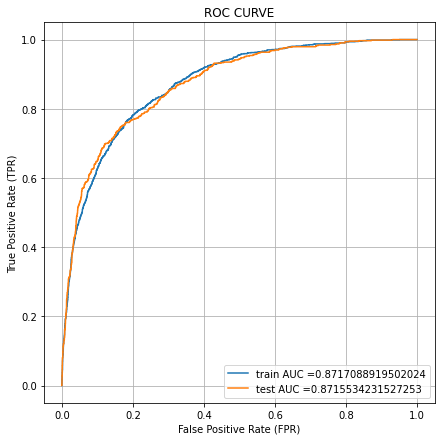

In [187]:
best_model = LogisticRegression(C=best_hyper_param)
best_model.fit(X_train_data_imp_features,y_train)

#https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-predict-and-predict-proba/67376/4
y_train_pred = best_model.predict_proba(X_train_data_imp_features)[:,1]
y_test_pred = best_model.predict_proba(X_test_data_imp_features)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test,y_test_pred)

#Plot roc curve, AUC cureve
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC CURVE")
plt.grid()
plt.show()

In [188]:
best_auc_lr = str(auc(test_fpr, test_tpr))

### Confusion Matrix for Logistic Regression

the maximum value of tpr*(1-fpr) 0.6261573770594673 for threshold 0.149


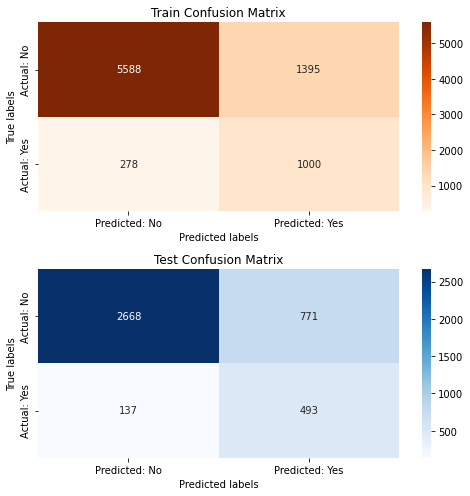

In [189]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_test_preicted = predict_with_best_t(y_test_pred, best_t)
train_conf = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test_conf = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))



#https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
import seaborn as sns
import matplotlib.pyplot as plt     

fig, ax= plt.subplots(nrows=2)
#https://stackoverflow.com/questions/41659188/how-to-adjust-subplot-size-in-seaborn
plt.rcParams['figure.figsize']=(7,7)

sns.heatmap(train_conf, annot=True,fmt="d",cmap='Oranges',ax=ax[0]);
# labels, title and ticks
ax[0].set_xlabel('Predicted labels');
ax[0].set_ylabel('True labels'); 
ax[0].set_ylim(2.0, 0)
ax[0].set_title('Train Confusion Matrix');
ax[0].xaxis.set_ticklabels(['Predicted: No','Predicted: Yes']); 
ax[0].yaxis.set_ticklabels(['Actual: No','Actual: Yes']);

sns.heatmap(test_conf, annot=True,fmt="d",cmap='Blues',ax=ax[1]);
# labels, title and ticks
ax[1].set_xlabel('Predicted labels');ax[1].set_ylabel('True labels'); 
ax[1].set_ylim(2.0, 0)
ax[1].set_title('Test Confusion Matrix');
ax[1].xaxis.set_ticklabels(['Predicted: No','Predicted: Yes']); 
ax[1].yaxis.set_ticklabels(['Actual: No','Actual: Yes']);


fig.tight_layout()

## Summary

In [190]:

from prettytable import PrettyTable

summary = PrettyTable()
summary.field_names = ["Model", "Hyper Parameter", "AUC"]
summary.add_row(["Decision Tree", str(max_depth)+'-'+str(min_samples_split), best_auc_dt])
summary.add_row(["Logistic Regression", round(best_hyper_param,3), best_auc_lr])
#summary.add_row(["GradientBoostingClassifier", str(best_n_estimators)+'-'+str(best_learning_rate), gbdt_auc])
print(summary)

+---------------------+-----------------+--------------------+
|        Model        | Hyper Parameter |        AUC         |
+---------------------+-----------------+--------------------+
|    Decision Tree    |      10-500     | 0.8804885141029369 |
| Logistic Regression |      100.0      | 0.8715534231527253 |
+---------------------+-----------------+--------------------+
